In [1]:
# !wget -O fluocells.zip http://amsacta.unibo.it/6706/1/fluocells.zip
# !unzip fluocells.zip

In [2]:
# %%capture
# !unzip ConferenceVideoSegmentationDataset.zip

In [3]:
%%capture
!pip install opacus

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image
import cv2
import opacus

In [17]:
def make_mask(data, index=0):
    return torch.where(data[index] > 0.5, 1.0, 0.).detach().cpu().numpy()[0]

In [18]:
class SegNN(nn.Module):
    def __init__(self):
        super(SegNN, self).__init__()
        
        self.first_part = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(64),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        
        self.second_part = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        f = self.first_part(x)
        return self.second_part(f)

In [34]:
class ConferenceDataset(Dataset):
    def __init__(self):
        
        self.images_path = './ConferenceVideoSegmentationDataset/original_training/'
        self.masks_path = './ConferenceVideoSegmentationDataset/ground_truth_training/'
        
        self.images_names = np.sort(os.listdir(self.images_path))[1:] # limiting the dataset size
        self.masks_names = np.sort(os.listdir(self.masks_path))[1:]
  
    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        
        im = np.array(Image.open(self.images_path + self.images_names[idx]).convert('RGB'))/255.
        
        im = cv2.resize(im, (320,180))
        im = torch.from_numpy(np.array(im)).permute(2, 0, 1).cuda().float()
        
        m = np.array(Image.open(self.masks_path + self.masks_names[idx]).convert('L'))/255.
        m = cv2.resize(m, (320,180))
        m = torch.from_numpy(np.array([m])).permute(0, 1, 2).cuda().float()
        
        return im, m

In [35]:
data = ConferenceDataset()

d1_len = (len(data)//5) * 4

dataset1, dataset2 = torch.utils.data.random_split(data, [d1_len, len(data) - d1_len])

In [36]:
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=4, shuffle=True)

In [37]:
model = SegNN().cuda()

# =============================================================

from opacus.validators import ModuleValidator

STEP_SIZE = 1e-3

# Also need to specify number of epochs and batch size
EPOCHS = 10
BATCH_SIZE = 4
MAX_PHYSICAL_BATCH_SIZE = 4

CLIPPING_THRESHOLD = 1.5
EPSILON = 1.1
DELTA = 1e-3


model = ModuleValidator.fix(model).cuda()
print(ModuleValidator.validate(model, strict=False))

# <- optimizer needs to be initialised with the new model !!!
optimizer = optim.Adam(model.parameters(), lr=1e-1) 
criterion = nn.BCELoss()

privacy_engine = opacus.PrivacyEngine()

model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=CLIPPING_THRESHOLD,
)

from opacus.privacy_engine import forbid_accumulation_hook

model.register_forward_pre_hook(forbid_accumulation_hook)

# =============================================================

[]


Train Epoch: 0 [0/1060 (0%)]	Loss: 0.750067
Train Epoch: 0 [40/1060 (4%)]	Loss: 0.585308
Train Epoch: 0 [80/1060 (8%)]	Loss: 0.581966
Train Epoch: 0 [120/1060 (11%)]	Loss: 0.522402
Train Epoch: 0 [160/1060 (15%)]	Loss: 0.550334
Train Epoch: 0 [200/1060 (19%)]	Loss: 0.453704
Train Epoch: 0 [240/1060 (23%)]	Loss: 0.506687
Train Epoch: 0 [280/1060 (26%)]	Loss: 0.459769
Train Epoch: 0 [320/1060 (30%)]	Loss: 0.504807
Train Epoch: 0 [360/1060 (34%)]	Loss: 0.370116
Train Epoch: 0 [400/1060 (38%)]	Loss: 0.441542
Train Epoch: 0 [440/1060 (42%)]	Loss: 0.384015
Train Epoch: 0 [480/1060 (45%)]	Loss: 0.489280
Train Epoch: 0 [520/1060 (49%)]	Loss: 0.313028
Train Epoch: 0 [560/1060 (53%)]	Loss: 0.333123
Train Epoch: 0 [600/1060 (57%)]	Loss: 0.422888
Train Epoch: 0 [640/1060 (60%)]	Loss: 0.477015
Train Epoch: 0 [680/1060 (64%)]	Loss: 0.560614
Train Epoch: 0 [720/1060 (68%)]	Loss: 0.406349
Train Epoch: 0 [760/1060 (72%)]	Loss: 0.409846
Train Epoch: 0 [800/1060 (75%)]	Loss: 0.445657
Train Epoch: 0 [840/

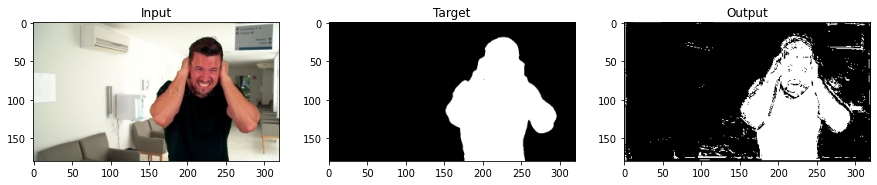

Train Epoch: 1 [0/1060 (0%)]	Loss: 0.323950
Train Epoch: 1 [40/1060 (4%)]	Loss: 0.372803
Train Epoch: 1 [80/1060 (8%)]	Loss: 0.313372
Train Epoch: 1 [120/1060 (11%)]	Loss: 0.426474
Train Epoch: 1 [160/1060 (15%)]	Loss: 0.340727
Train Epoch: 1 [200/1060 (19%)]	Loss: 0.256904
Train Epoch: 1 [240/1060 (23%)]	Loss: 0.340236
Train Epoch: 1 [280/1060 (26%)]	Loss: 0.392669
Train Epoch: 1 [320/1060 (30%)]	Loss: 0.348659
Train Epoch: 1 [360/1060 (34%)]	Loss: 0.203300
Train Epoch: 1 [400/1060 (38%)]	Loss: 0.328954
Train Epoch: 1 [440/1060 (42%)]	Loss: 0.250176
Train Epoch: 1 [480/1060 (45%)]	Loss: 0.233821
Train Epoch: 1 [520/1060 (49%)]	Loss: 0.405064
Train Epoch: 1 [560/1060 (53%)]	Loss: 0.237895
Train Epoch: 1 [600/1060 (57%)]	Loss: 0.439727
Train Epoch: 1 [640/1060 (60%)]	Loss: 0.381567
Train Epoch: 1 [680/1060 (64%)]	Loss: 0.363452
Train Epoch: 1 [720/1060 (68%)]	Loss: 0.248177
Train Epoch: 1 [760/1060 (72%)]	Loss: 0.436919
Train Epoch: 1 [800/1060 (75%)]	Loss: 0.275406
Train Epoch: 1 [840/

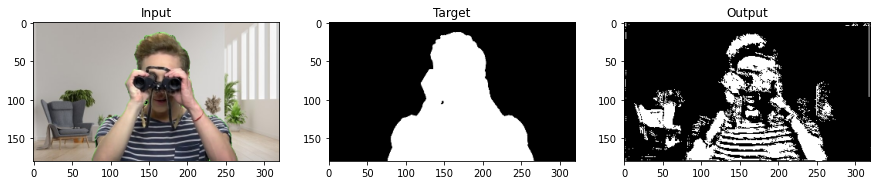

Train Epoch: 2 [0/1060 (0%)]	Loss: 0.261714
Train Epoch: 2 [40/1060 (4%)]	Loss: 0.288887
Train Epoch: 2 [80/1060 (8%)]	Loss: 0.194456
Train Epoch: 2 [120/1060 (11%)]	Loss: 0.279754
Train Epoch: 2 [160/1060 (15%)]	Loss: 0.255455
Train Epoch: 2 [200/1060 (19%)]	Loss: 0.189557
Train Epoch: 2 [240/1060 (23%)]	Loss: 0.293067
Train Epoch: 2 [280/1060 (26%)]	Loss: 0.255275
Train Epoch: 2 [320/1060 (30%)]	Loss: 0.288747
Train Epoch: 2 [360/1060 (34%)]	Loss: 0.297264
Train Epoch: 2 [400/1060 (38%)]	Loss: 0.166536
Train Epoch: 2 [440/1060 (42%)]	Loss: 0.309375
Train Epoch: 2 [480/1060 (45%)]	Loss: 0.257452
Train Epoch: 2 [520/1060 (49%)]	Loss: 0.254245
Train Epoch: 2 [560/1060 (53%)]	Loss: 0.278629
Train Epoch: 2 [600/1060 (57%)]	Loss: 0.192259
Train Epoch: 2 [640/1060 (60%)]	Loss: 0.152773
Train Epoch: 2 [680/1060 (64%)]	Loss: 0.157773
Train Epoch: 2 [720/1060 (68%)]	Loss: 0.156486
Train Epoch: 2 [760/1060 (72%)]	Loss: 0.205202
Train Epoch: 2 [800/1060 (75%)]	Loss: 0.282421
Train Epoch: 2 [840/

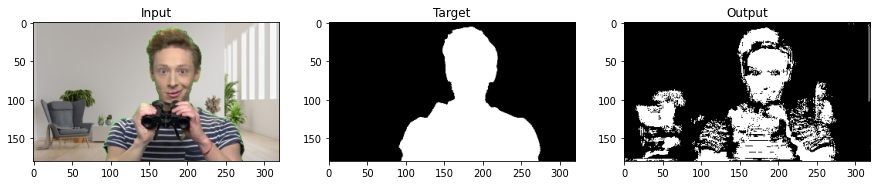

Train Epoch: 3 [0/1060 (0%)]	Loss: 0.301486
Train Epoch: 3 [40/1060 (4%)]	Loss: 0.252754
Train Epoch: 3 [80/1060 (8%)]	Loss: 0.271891
Train Epoch: 3 [120/1060 (11%)]	Loss: 0.247080
Train Epoch: 3 [160/1060 (15%)]	Loss: 0.224779
Train Epoch: 3 [200/1060 (19%)]	Loss: 0.223821
Train Epoch: 3 [240/1060 (23%)]	Loss: 0.244901
Train Epoch: 3 [280/1060 (26%)]	Loss: 0.308373
Train Epoch: 3 [320/1060 (30%)]	Loss: 0.216848
Train Epoch: 3 [360/1060 (34%)]	Loss: 0.206117
Train Epoch: 3 [400/1060 (38%)]	Loss: 0.197340
Train Epoch: 3 [440/1060 (42%)]	Loss: 0.303732
Train Epoch: 3 [480/1060 (45%)]	Loss: 0.362580
Train Epoch: 3 [520/1060 (49%)]	Loss: 0.258011
Train Epoch: 3 [560/1060 (53%)]	Loss: 0.205789
Train Epoch: 3 [600/1060 (57%)]	Loss: 0.266532
Train Epoch: 3 [640/1060 (60%)]	Loss: 0.155262
Train Epoch: 3 [680/1060 (64%)]	Loss: 0.198326
Train Epoch: 3 [720/1060 (68%)]	Loss: 0.293662
Train Epoch: 3 [760/1060 (72%)]	Loss: 0.234974
Train Epoch: 3 [800/1060 (75%)]	Loss: 0.380467
Train Epoch: 3 [840/

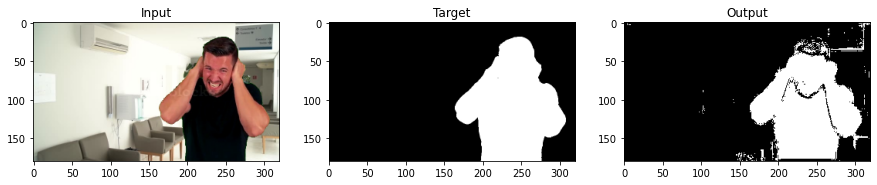

Train Epoch: 4 [0/1060 (0%)]	Loss: 0.194233
Train Epoch: 4 [40/1060 (4%)]	Loss: 0.209161
Train Epoch: 4 [80/1060 (8%)]	Loss: 0.247076
Train Epoch: 4 [120/1060 (11%)]	Loss: 0.251644
Train Epoch: 4 [160/1060 (15%)]	Loss: 0.283256
Train Epoch: 4 [200/1060 (19%)]	Loss: 0.144169
Train Epoch: 4 [240/1060 (23%)]	Loss: 0.133332
Train Epoch: 4 [280/1060 (26%)]	Loss: 0.199185
Train Epoch: 4 [320/1060 (30%)]	Loss: 0.271118
Train Epoch: 4 [360/1060 (34%)]	Loss: 0.142711
Train Epoch: 4 [400/1060 (38%)]	Loss: 0.289727
Train Epoch: 4 [440/1060 (42%)]	Loss: 0.285385
Train Epoch: 4 [480/1060 (45%)]	Loss: 0.213521
Train Epoch: 4 [520/1060 (49%)]	Loss: 0.250100
Train Epoch: 4 [560/1060 (53%)]	Loss: 0.201225
Train Epoch: 4 [600/1060 (57%)]	Loss: 0.253652
Train Epoch: 4 [640/1060 (60%)]	Loss: 0.199430
Train Epoch: 4 [680/1060 (64%)]	Loss: 0.247114
Train Epoch: 4 [720/1060 (68%)]	Loss: 0.282147
Train Epoch: 4 [760/1060 (72%)]	Loss: 0.294198
Train Epoch: 4 [800/1060 (75%)]	Loss: 0.286504
Train Epoch: 4 [840/

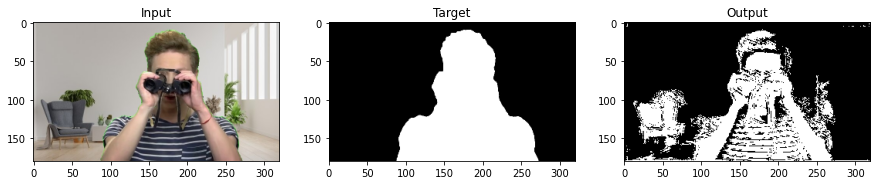

Train Epoch: 5 [0/1060 (0%)]	Loss: 0.318440
Train Epoch: 5 [40/1060 (4%)]	Loss: 0.180507
Train Epoch: 5 [80/1060 (8%)]	Loss: 0.233140
Train Epoch: 5 [120/1060 (11%)]	Loss: 0.197015
Train Epoch: 5 [160/1060 (15%)]	Loss: 0.277606
Train Epoch: 5 [200/1060 (19%)]	Loss: 0.231383
Train Epoch: 5 [240/1060 (23%)]	Loss: 0.275702
Train Epoch: 5 [280/1060 (26%)]	Loss: 0.154292
Train Epoch: 5 [320/1060 (30%)]	Loss: 0.282860
Train Epoch: 5 [360/1060 (34%)]	Loss: 0.165218
Train Epoch: 5 [400/1060 (38%)]	Loss: 0.285170
Train Epoch: 5 [440/1060 (42%)]	Loss: 0.241612
Train Epoch: 5 [480/1060 (45%)]	Loss: 0.246962
Train Epoch: 5 [520/1060 (49%)]	Loss: 0.230068
Train Epoch: 5 [560/1060 (53%)]	Loss: 0.219339
Train Epoch: 5 [600/1060 (57%)]	Loss: 0.259161
Train Epoch: 5 [640/1060 (60%)]	Loss: 0.179192
Train Epoch: 5 [680/1060 (64%)]	Loss: 0.241558
Train Epoch: 5 [720/1060 (68%)]	Loss: 0.218988
Train Epoch: 5 [760/1060 (72%)]	Loss: 0.281136
Train Epoch: 5 [800/1060 (75%)]	Loss: 0.211269
Train Epoch: 5 [840/

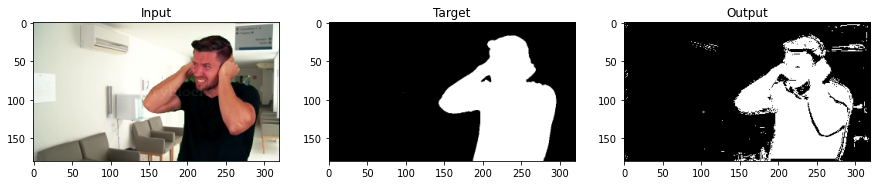

Train Epoch: 6 [0/1060 (0%)]	Loss: 0.250963
Train Epoch: 6 [40/1060 (4%)]	Loss: 0.212617
Train Epoch: 6 [80/1060 (8%)]	Loss: 0.198087
Train Epoch: 6 [120/1060 (11%)]	Loss: 0.204470
Train Epoch: 6 [160/1060 (15%)]	Loss: 0.218955
Train Epoch: 6 [200/1060 (19%)]	Loss: 0.182860
Train Epoch: 6 [240/1060 (23%)]	Loss: 0.172526
Train Epoch: 6 [280/1060 (26%)]	Loss: 0.213189
Train Epoch: 6 [320/1060 (30%)]	Loss: 0.209792
Train Epoch: 6 [360/1060 (34%)]	Loss: 0.222983
Train Epoch: 6 [400/1060 (38%)]	Loss: 0.256081
Train Epoch: 6 [440/1060 (42%)]	Loss: 0.222318
Train Epoch: 6 [480/1060 (45%)]	Loss: 0.240820
Train Epoch: 6 [520/1060 (49%)]	Loss: 0.185512
Train Epoch: 6 [560/1060 (53%)]	Loss: 0.225069
Train Epoch: 6 [600/1060 (57%)]	Loss: 0.238991
Train Epoch: 6 [640/1060 (60%)]	Loss: 0.264693
Train Epoch: 6 [680/1060 (64%)]	Loss: 0.269371
Train Epoch: 6 [720/1060 (68%)]	Loss: 0.229122
Train Epoch: 6 [760/1060 (72%)]	Loss: 0.216985
Train Epoch: 6 [800/1060 (75%)]	Loss: 0.226390
Train Epoch: 6 [840/

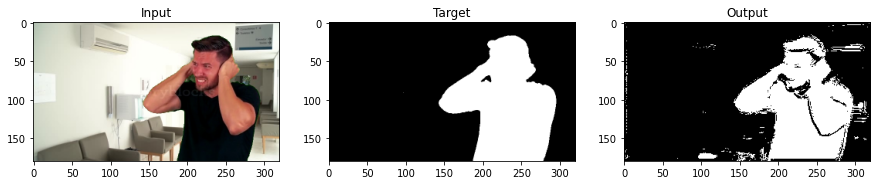

Train Epoch: 7 [0/1060 (0%)]	Loss: 0.255538
Train Epoch: 7 [40/1060 (4%)]	Loss: 0.215052
Train Epoch: 7 [80/1060 (8%)]	Loss: 0.268846
Train Epoch: 7 [120/1060 (11%)]	Loss: 0.237605
Train Epoch: 7 [160/1060 (15%)]	Loss: 0.149844
Train Epoch: 7 [200/1060 (19%)]	Loss: 0.301523
Train Epoch: 7 [240/1060 (23%)]	Loss: 0.240056
Train Epoch: 7 [280/1060 (26%)]	Loss: 0.185865
Train Epoch: 7 [320/1060 (30%)]	Loss: 0.241232
Train Epoch: 7 [360/1060 (34%)]	Loss: 0.233480
Train Epoch: 7 [400/1060 (38%)]	Loss: 0.257364
Train Epoch: 7 [440/1060 (42%)]	Loss: 0.189068
Train Epoch: 7 [480/1060 (45%)]	Loss: 0.187328
Train Epoch: 7 [520/1060 (49%)]	Loss: 0.207923
Train Epoch: 7 [560/1060 (53%)]	Loss: 0.221989
Train Epoch: 7 [600/1060 (57%)]	Loss: 0.199928
Train Epoch: 7 [640/1060 (60%)]	Loss: 0.200213
Train Epoch: 7 [680/1060 (64%)]	Loss: 0.161491
Train Epoch: 7 [720/1060 (68%)]	Loss: 0.281394
Train Epoch: 7 [760/1060 (72%)]	Loss: 0.193601
Train Epoch: 7 [800/1060 (75%)]	Loss: 0.249530
Train Epoch: 7 [840/

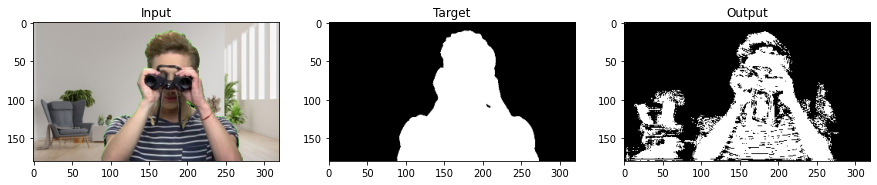

Train Epoch: 8 [0/1060 (0%)]	Loss: 0.206362
Train Epoch: 8 [40/1060 (4%)]	Loss: 0.143297
Train Epoch: 8 [80/1060 (8%)]	Loss: 0.199517
Train Epoch: 8 [120/1060 (11%)]	Loss: 0.193751
Train Epoch: 8 [160/1060 (15%)]	Loss: 0.257754
Train Epoch: 8 [200/1060 (19%)]	Loss: 0.203297
Train Epoch: 8 [240/1060 (23%)]	Loss: 0.220472
Train Epoch: 8 [280/1060 (26%)]	Loss: 0.130657
Train Epoch: 8 [320/1060 (30%)]	Loss: 0.149277
Train Epoch: 8 [360/1060 (34%)]	Loss: 0.178631
Train Epoch: 8 [400/1060 (38%)]	Loss: 0.129795
Train Epoch: 8 [440/1060 (42%)]	Loss: 0.144566
Train Epoch: 8 [480/1060 (45%)]	Loss: 0.260354
Train Epoch: 8 [520/1060 (49%)]	Loss: 0.161964
Train Epoch: 8 [560/1060 (53%)]	Loss: 0.289831
Train Epoch: 8 [600/1060 (57%)]	Loss: 0.225825
Train Epoch: 8 [640/1060 (60%)]	Loss: 0.152814
Train Epoch: 8 [680/1060 (64%)]	Loss: 0.179904
Train Epoch: 8 [720/1060 (68%)]	Loss: 0.243732
Train Epoch: 8 [760/1060 (72%)]	Loss: 0.160571
Train Epoch: 8 [800/1060 (75%)]	Loss: 0.195603
Train Epoch: 8 [840/

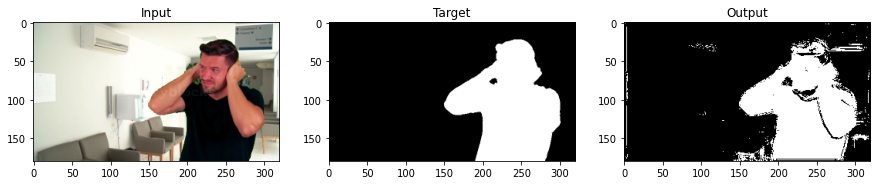

Train Epoch: 9 [0/1060 (0%)]	Loss: 0.212857
Train Epoch: 9 [40/1060 (4%)]	Loss: 0.175261
Train Epoch: 9 [80/1060 (8%)]	Loss: 0.117207
Train Epoch: 9 [120/1060 (11%)]	Loss: 0.217670
Train Epoch: 9 [160/1060 (15%)]	Loss: 0.125174
Train Epoch: 9 [200/1060 (19%)]	Loss: 0.199594
Train Epoch: 9 [240/1060 (23%)]	Loss: 0.204118
Train Epoch: 9 [280/1060 (26%)]	Loss: 0.216589
Train Epoch: 9 [320/1060 (30%)]	Loss: 0.253008
Train Epoch: 9 [360/1060 (34%)]	Loss: 0.153949
Train Epoch: 9 [400/1060 (38%)]	Loss: 0.198357
Train Epoch: 9 [440/1060 (42%)]	Loss: 0.174452
Train Epoch: 9 [480/1060 (45%)]	Loss: 0.220708
Train Epoch: 9 [520/1060 (49%)]	Loss: 0.226951
Train Epoch: 9 [560/1060 (53%)]	Loss: 0.214604
Train Epoch: 9 [600/1060 (57%)]	Loss: 0.171838
Train Epoch: 9 [640/1060 (60%)]	Loss: 0.139958
Train Epoch: 9 [680/1060 (64%)]	Loss: 0.214043
Train Epoch: 9 [720/1060 (68%)]	Loss: 0.128094
Train Epoch: 9 [760/1060 (72%)]	Loss: 0.139909
Train Epoch: 9 [800/1060 (75%)]	Loss: 0.158558
Train Epoch: 9 [840/

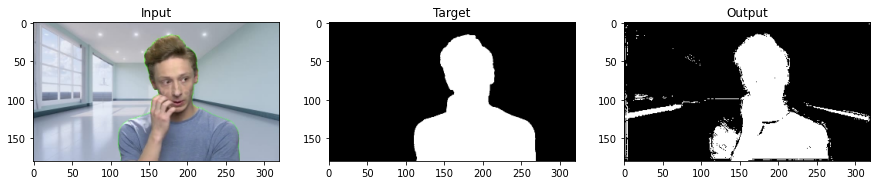

In [38]:
model.train()

INDEX=0

multiplier_init = 0.25
multiplier = multiplier_init

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    a1 = data[INDEX].permute(1,2,0).detach().cpu().numpy()
    a2 = target.detach().cpu().numpy()[INDEX,0]

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(a1)
    plt.title('Input')
    plt.subplot(1,3,2)
    plt.imshow(a2, cmap='gray')
    plt.title('Target')
    plt.subplot(1,3,3)
    plt.imshow(make_mask(output, INDEX), cmap='gray')
    plt.title('Output')
    plt.show()

    if epoch % 5 == 0:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1e-1 * multiplier
            multiplier *= multiplier_init

---

In [39]:
class AttackerNN(nn.Module):
    def __init__(self):
        super(AttackerNN, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.layers(x)

In [40]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=4, shuffle=True)

Attacker train epoch: 0	Loss: 0.008227
Attacker train epoch: 1	Loss: 0.006918
Attacker train epoch: 2	Loss: 0.005930
Attacker train epoch: 3	Loss: 0.004249
Attacker train epoch: 4	Loss: 0.005334


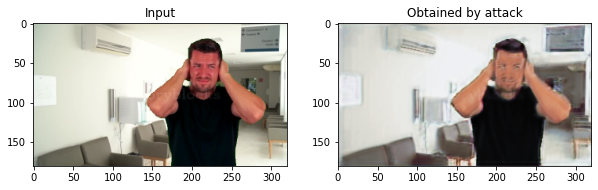

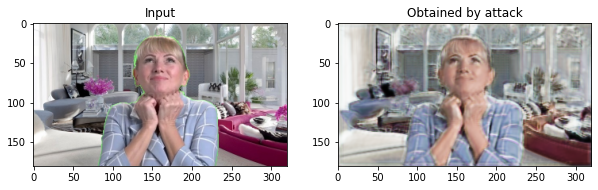

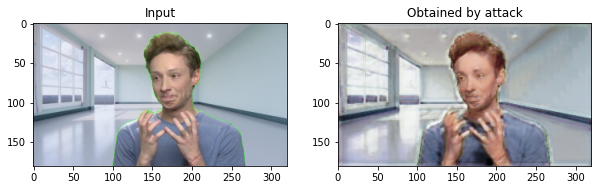

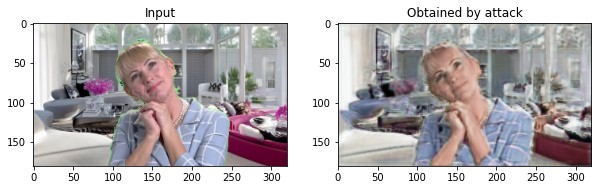

In [42]:
EPOCHS=5

model.eval()

attacker_model = AttackerNN().cuda()
optimiser = optim.Adam(attacker_model.parameters(), lr=1e-2)
mse_loss = nn.MSELoss().cuda()

attacker_model.train()

for epoch in range(EPOCHS):
    
    for batch_idx, (data, target) in enumerate(test_loader):

        optimiser.zero_grad()

        with torch.no_grad():
            target_outputs = model.first_part(data)

        attack_outputs = attacker_model(target_outputs)

        loss = mse_loss(data, attack_outputs)

        loss.backward()
        optimiser.step()
        
    if epoch % 1 == 0:
        print('Attacker train epoch: {}\tLoss: {:.6f}'.format(epoch, loss.item()))
        
    if epoch == (EPOCHS - 1):
        for batch_idx, (data, target) in enumerate(test_loader):

            target_outputs = model.first_part(data)
            attack_outputs = attacker_model(target_outputs)
            loss = nn.MSELoss()(data, attack_outputs)

            for i in range(len(data)):

                im_input = data[i].permute(1,2,0).detach().cpu().numpy()
                im_attack = attack_outputs[i].permute(1,2,0).detach().cpu().numpy()

                plt.figure(figsize=(10,10))
                plt.subplot(1,2,1)
                plt.imshow(im_input, cmap='gray')
                plt.title('Input')
                plt.subplot(1,2,2)
                plt.imshow(im_attack)
                plt.title('Obtained by attack')
                plt.show()
                
            break